 master-thesisInput:
- True Observations
- Number Training Steps

Output:
- New Model Parameter

Parts of Optimization:
- Initialization of Model Parameter
- tbd

# Initialization

## Import Libraries and Mount Drive

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
from torch import distributions, optim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GitHub/master-thesis

import sys
sys.path.append('/content/gdrive/My Drive/GitHub/master-thesis')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GitHub/master-thesis


In [3]:
#%cd ..

In [4]:
from model.methods import *
from model.modelcore import epid_model
from model.modelhelper import *

## Optimization Settings

In [5]:
start_time='2020-09-15'
end_time='2021-01-15'
observation = 'hospitalization' #'newly_infected' #'hospitalization' 


dtype = torch.float32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #cuda:0

## Initialize Observations

In [6]:
df_obs_initial = pd.read_csv('data/220309_observations.csv' , sep=';', thousands='.', decimal=',', encoding='utf-8', parse_dates=['Date'])
df_obs, initial_newly_infected = initialize_observations(df_obs_initial, start=start_time, end=end_time)
observed = torch.tensor(df_obs[observation], requires_grad=False, device=device, dtype=dtype)
print(initial_newly_infected)
df_obs.head(3)

[293 367 346 301 296 380]


,Date,number_of_deaths,newly_infected,hospitalization
0,2020-09-15,1,435,14
1,2020-09-16,1,549,21
2,2020-09-17,0,516,13


In [7]:
#for column in df_obs.columns:
#  plt.plot(df_obs['Date'], df_obs[column])
#  plt.title(column)
#  plt.show()

## Initialize Model Parameter

### Initialize helper parameter

In [8]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)
num_observations = df_obs.shape[0]
population = torch.tensor(5793636, requires_grad=False, device=device, dtype=dtype)

### Initialize method parameter

In [9]:
method = TwoClusterNN(num_observations, device=device, dtype=dtype)

### Initialize alpha and phi

In [10]:
dict_param = initialize_parameter(['alpha', 'phi'], device, dtype)
dict_param

{'prime_values': {'alpha': tensor(-0.0746, requires_grad=True),
  'phi': tensor(-0., requires_grad=True)},
 'real_values': {'alpha': tensor(0.0100, grad_fn=<AddBackward0>),
  'phi': tensor(25., grad_fn=<AddBackward0>)}}

## Load Method Input Data

In [11]:
def get_input_data(start, end):
  df_cluster = pd.read_csv('data/clustering/220309_percentage_careful.csv' , parse_dates=['date'])
  df_cluster['percentage'] = df_cluster['percentage'].rolling(7).mean()
  time_period = (df_cluster['date'] >= start) & (df_cluster['date'] < end)
  input_data = df_cluster.loc[time_period]['percentage'].copy()
  return input_data.to_numpy()

cluster_percentage = get_input_data(start_time, end_time)

cluster_percentage

array([0.66555097, 0.66388143, 0.66350461, 0.66493214, 0.66387196,
       0.65891288, 0.65861836, 0.65803932, 0.66413519, 0.65547342,
       0.65223196, 0.65413972, 0.65549271, 0.65470901, 0.66099631,
       0.6586284 , 0.66091153, 0.66523724, 0.66309138, 0.65954916,
       0.66057365, 0.65963145, 0.65572727, 0.65880603, 0.64983244,
       0.65289573, 0.64819219, 0.62950871, 0.61840669, 0.60798971,
       0.60094947, 0.60486398, 0.60557296, 0.610484  , 0.62250706,
       0.62875304, 0.63901692, 0.6442434 , 0.64518044, 0.65172101,
       0.66558701, 0.67136547, 0.67777097, 0.68446907, 0.68730556,
       0.69224672, 0.69056838, 0.6955367 , 0.70023374, 0.70556218,
       0.6955118 , 0.70177327, 0.70544134, 0.70705458, 0.69404733,
       0.69471345, 0.68134168, 0.69107779, 0.67831415, 0.67331415,
       0.67331259, 0.67596991, 0.67272556, 0.6810257 , 0.68160139,
       0.68298375, 0.68223144, 0.68190414, 0.68350407, 0.68105158,
       0.67274916, 0.67805659, 0.68554624, 0.68280647, 0.68587

# Optimization

## Training

In [12]:
epochs = 10000
model_parameter = [dict_param['prime_values']['alpha'], dict_param['prime_values']['phi']]

params_to_be_optimized = method.get_parameters()
#if observation == 'hospitalization':
#  params_to_be_optimized = params_to_be_optimized + model_parameter #[dict_param['prime_values']['alpha']]

optimizer = optim.Adam(params_to_be_optimized, lr=0.0001)

for i in range(epochs):
  start_time = time.time()
  optimizer.zero_grad()

  # transform alphi, phi
  transform_prime_variables(dict_param)

  # forward pass
  expected = epid_model(population, R=method.calculate_R(cluster_percentage), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
  
  # calc loss
  comparison_loss =  calc_mse(expected, observed) #* dict_param['real_values']['phi']
  method_loss = method.calculate_loss()
  model_param_loss = calc_prior_loss(dict_param, device, dtype)
  loss = comparison_loss #+ method_loss #+ model_param_loss

  # backward pass
  loss.backward()
  optimizer.step()

  if i % 50==0:
      print(f'Step: {i}, Time: {time.time() - start_time}, Loss: {loss}, Mean Expected Daily Hospit: {expected.cpu().detach().numpy().mean()}')
      plt.plot(method.calculate_R(cluster_percentage).cpu().detach().numpy(), label='R')
      plt.plot(cluster_percentage, label='cluster')
      plt.legend()
      plt.show()
  if i % 100==0:
    #print(method.calculate_R(cluster_percentage))
    plt.plot(df_obs['Date'], expected.cpu().detach().numpy(), label='predicted')
    plt.plot(df_obs['Date'], observed.cpu().detach().numpy(), label='observed')
    plt.legend()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

# Evaluation

In [29]:
expected_normal = epid_model(population, R=method.calculate_R(cluster_percentage), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]



expected_careful= epid_model(population, R=method.calculate_R(cluster_percentage+0.05), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]

expected_crazy = epid_model(population, R=method.calculate_R(cluster_percentage-0.05), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]

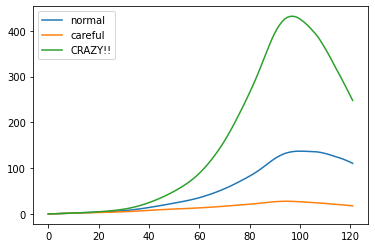

In [30]:
plt.plot(expected_normal.cpu().detach().numpy(),label='normal')
plt.plot(expected_careful.cpu().detach().numpy(),label='careful')
plt.plot(expected_crazy.cpu().detach().numpy(),label='CRAZY!!')
plt.legend()
plt.show()

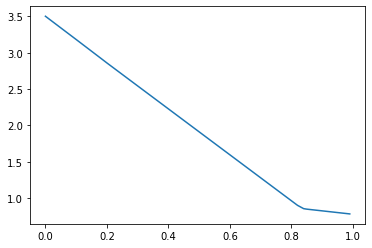

In [32]:
x = np.arange(0,1 , 0.01)
plt.plot(x, method.calculate_R(x).cpu().detach().numpy())
plt.show()